In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Colab\ Notebooks/files/CS5691/Assignment2

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/files/CS5691/Assignment2


In [ ]:
# make sure the data path is same
# for now, it is in "Data_1A/8/train.csv",...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from numpy.linalg import inv, norm
from mpl_toolkits import mplot3d
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn import neighbors, datasets
import os
import math
import pickle

# Utilities

In [ ]:
#utility functions

#calculate the distance of the training examples with the test_data point
def distance(train,test_input):
    distances = np.zeros_like((train.shape[0],train.shape[1]+1))
    norms = norm(train[:,:len(train[0])-1] - test_input[:2], axis = 1)
    norms = np.reshape(norms,(len(norms),1))
    distances = np.append(train,norms, axis = 1)
    return distances
    
def get_neighbors(train,test_input,k=1):
    distances = distance(train, test_input)
    sorted_distances = distances[np.argsort(distances[:, -1])]
    #collecting the first k neighbors
    neighbors = np.zeros_like(distances[:k])
    neighbors = sorted_distances[:k]
    return neighbors

# Make a classification prediction with neighbors
def knn_predict_classification(train, test_input, k=1):
	neighbors = get_neighbors(train, test_input, k=1)
	output_values = [row[-2] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

def knn_classifier(train,test,k=1):
    predictions = []
    if test.shape == (train.shape[1],) :
        output = knn_predict_classification(train,test,k)
        predictions.append(output)
    else :
        for row in test:
            output = knn_predict_classification(train,row,k)
            predictions.append(output)
    return predictions

def knn_performance(train, x, y, k=1):
    out_classes = set(y)
    L = len(out_classes)
    N = x.shape[0]
    y_pred = knn_classifier(train,x,k=k)
    confusion_matrix = np.zeros((L,L))
    for i in range(N):
        confusion_matrix[int(y_pred[i]), int(y[i])] += 1
    acc = (np.trace(confusion_matrix)/N)*100
    for i in range(L):
        confusion_matrix[:,i] = confusion_matrix[:,i]/(y==i).sum()
    return confusion_matrix,acc

def knn_decision_regions(train,k=1):
    x1_min,x1_max = train[:,0].min(),train[:,0].max()
    x2_min,x2_max = train[:,1].min(),train[:,1].max()
    x = np.linspace(x1_min,x1_max,300)
    y = np.linspace(x2_min,x2_max,300)
    X,Y = np.meshgrid(x,y)
    Z = knn_classifier(train, np.c_[X.ravel(), Y.ravel()],k)
    Z = np.array(Z).reshape(X.shape)
    return X,Y,Z

def naive_bayes_classifier(x,y,classifier_type=0):
    L = int(np.max(y))+1
    prior_prob = []
    means = []
    covariance_matrices = []
    probs = []
    k = x.shape[1]
    n = x.shape[0]
    sigma2 = 0
    covariance_matrix = np.zeros((k,k))
    for l in range(L):
        x_class = X_train[Y_train == l]
        nl = x_class.shape[0]
        prior_prob.append(nl/n)
        means.append(np.mean(x_class, axis=0))
        tmp = x_class - means[-1]
        if(classifier_type == 0):
            sigma2 += np.sum(tmp**2)
        if(classifier_type == 1):
            covariance_matrix = covariance_matrix + np.matmul(tmp.T, tmp)
        if(classifier_type == 2):
            covariance_matrix = np.matmul(tmp.T, tmp)
            covariance_matrix = covariance_matrix*np.eye(k)
            covariance_matrices.append(covariance_matrix/nl)
    
    if(classifier_type == 1):
        covariance_matrix = covariance_matrix/n
        covariance_matrix = covariance_matrix*np.eye(k)
        for i in range(L):
            covariance_matrices.append(covariance_matrix)

    if(classifier_type == 0):
        sigma2 = sigma2/(n*k)
        covariance_matrix = sigma2*np.eye(k)
        for i in range(L):
            covariance_matrices.append(covariance_matrix)
    
    for i in range(L):
        probs.append(multivariate_normal(mean=means[i], cov=covariance_matrices[i]))

    return prior_prob, probs

def naive_bayes_predict(x, class_prob, prior_prob):
    posterior_prob = []
    L = len(prior_prob)
    for i in range(L):
        tmp = class_prob[i].pdf(x)
        tmp = tmp*prior_prob[i]
        posterior_prob.append(tmp)
    return (np.argmax(posterior_prob))
    
def naive_bayes_decision_regions(X_train, class_prob, prior_prob):
    x = np.linspace(-12,12,300)
    y = np.linspace(-12,4,300)
    X,Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y #pos = np.dstack((X,Y)) #tz
    L = len(class_prob)

    Z = np.empty(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i][j] = 3-naive_bayes_predict([X[i,j], Y[i,j]], class_prob, prior_prob)
    return X,Y,Z,pos

def naive_bayes_performance(x, y, class_prob, prior_prob):
    L = len(prior_prob)
    N = x.shape[0]
    y_pred = []
    for n in range(N):
        y_pred.append(naive_bayes_predict(x[n], class_prob, prior_prob))
    confusion_matrix = np.zeros((L,L))
    for i in range(N):
        confusion_matrix[y_pred[i], int(y[i])] += 1
    acc = (np.trace(confusion_matrix)/N)*100
    for i in range(L):
        confusion_matrix[:,i] = confusion_matrix[:,i]/(y==i).sum()
    return confusion_matrix,acc

def make_diagonal(X):
    for i in range(X.shape[0]):
        for j in range(i+1, X.shape[0], 1):
            X[i][j] = 0
            X[j][i] = 0
    return X

# Dataset 1A

In [ ]:
#reading the training data and storing the features and outputs in corresponding variables
df_train= pd.read_csv("Data_1A/8/train.csv",header=None)
df_train.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_train['y']=df_train['y'].astype('int32')
train_data = np.array(df_train[['x1','x2','y']]) 
X_train = np.array(df_train[['x1','x2']]) 
X1_train = train_data[:,0]; X2_train = train_data[:,1] ; Y_train = train_data[:,2]

#reading the test data and storing the features and outputs in corresponding variables
df_test= pd.read_csv("Data_1A/8/dev.csv",header=None)
df_test.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_test['y']=df_test['y'].astype('int32')
test_data = np.array(df_test[['x1','x2','y']])
N_dev = test_data.shape[0]
np.random.shuffle(test_data)
X_test = test_data[:N_dev//2, [0,1]]; Y_test = test_data[:N_dev//2,2]
X1_test = X_test[:,0]; X2_test = X_test[:,1];
cv_data = test_data[N_dev//2:,:]
X_cv = test_data[N_dev//2:, [0,1]]; Y_cv = test_data[N_dev//2:,2]
X1_cv = X_cv[:,0]; X2_cv = X_cv[:,1];

In [ ]:
# df_val contains validation data and df_test_ contains test data (df_test was used already)

def get_cv_data(df_dev):
    
    df_val=pd.DataFrame(columns=['x1','x2','y'])
    df_test_=pd.DataFrame(columns=['x1','x2','y'])
    num_classes=4    
    for i in range(num_classes):
        df_i=df_dev[df_dev['y']==i]          # df containing test data of class i
        indx=np.random.permutation(df_i.shape[0])
        df_i_val=df_i.iloc[indx[0:15]]
        df_i_test=df_i.iloc[indx[15:30]]
        df_val=df_val.append(df_i_val)
        df_test_=df_test_.append(df_i_test)
    return (df_val,df_test_)

df_val,df_test_=get_cv_data(df_test)

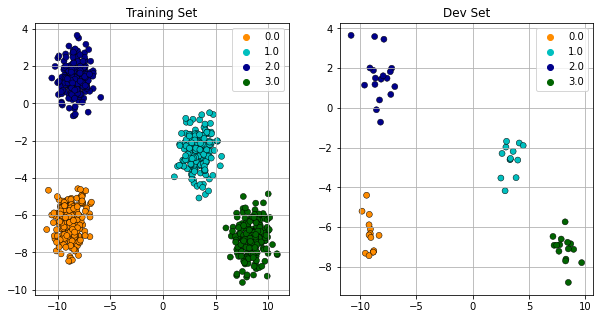

In [ ]:
cmap_bold = ['darkorange', 'c', 'darkblue','darkgreen']         #defining the cmap_bold
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue', 'green']) #definig the cmap_light for decision boundaries 
#Visualising the dataset in 2d
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.grid()
# for i in range(4):
#     each_class_df=df_train[df_train['y']==i]
#     plt.scatter(each_class_df['x1'],each_class_df['x2'],label='Class'+str(i), s=5)
sns.scatterplot(x=X1_train, y=X2_train, hue=Y_train,palette=cmap_bold, alpha=1.0, edgecolor="black")
                
plt.legend()
plt.title("Training Set")
plt.subplot(1,2,2)
plt.grid()
# for i in range(4):
#     each_class_df=df_test[df_test['y']==i]
#     plt.scatter(each_class_df['x1'],each_class_df['x2'],label='Class'+str(i), s=5)
sns.scatterplot(x=X1_test, y=X2_test, hue=Y_test,palette=cmap_bold, alpha=1.0, edgecolor="black")
plt.legend()
plt.title("Dev Set")
plt.show()

### KNN classifier 

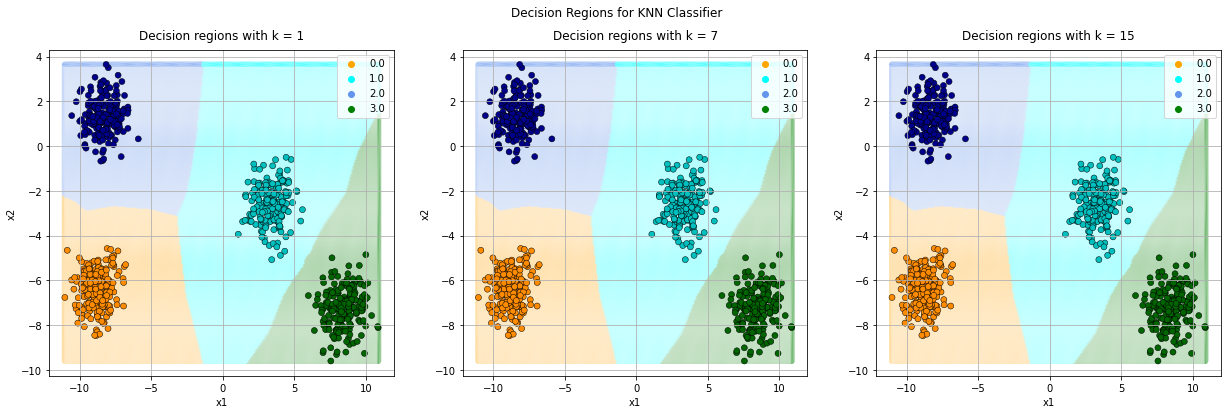

In [ ]:
titles = ['k = 1', 'k = 7', 'k = 15']
k = [1,7,15]
#plotting the decision regions
plt.figure(figsize=(21,6))
plt.suptitle("Decision Regions for KNN Classifier")
for i in range(3):
    X,Y,Z = knn_decision_regions(train_data,k[i])
    plt.subplot(1,3,i+1)
    plt.grid()
    plt.title("Decision regions with "+titles[i], pad=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    sns.scatterplot(x = X.ravel(),y = Y.ravel(), hue = Z.ravel(),palette=cmap_light,legend= True)
    sns.scatterplot(x=X1_train, y=X2_train, hue=Y_train,palette=cmap_bold, alpha=1.0, edgecolor="black",legend=False)

plt.show()

In [ ]:
#table of accuracies of KNN classifier with different values of k
df = pd.DataFrame(np.zeros((3,3)))
actual_cv = Y_cv
actual_train = Y_train
score_cv,score_train = [],[]
for i in range(3):

    predicted_cv = knn_classifier(train_data,cv_data,k[i])
    score_cv.append(accuracy_metric(actual_cv,predicted_cv))
    predicted_train = knn_classifier(train_data,train_data,k[i])
    score_train.append(accuracy_metric(actual_train,predicted_train))


    df.iloc[i,0] = "Accuracy with " + titles[i]
    df.iloc[i,1] = score_train[i]
    df.iloc[i,2] = score_cv[i]

df.rename(columns={0:"", 1:"Training Accuracy (%)", 2:"Validation Accuracy (%)"}, inplace=True)
df.set_index("", inplace=True)
df

,Training Accuracy (%),Validation Accuracy (%)
,,
Accuracy with k = 1,100.0,100.0
Accuracy with k = 7,100.0,100.0
Accuracy with k = 15,100.0,100.0


Accuracy of KNN on :
1 ) Training set: 100.0 %
2 ) Test set: 100.0 %



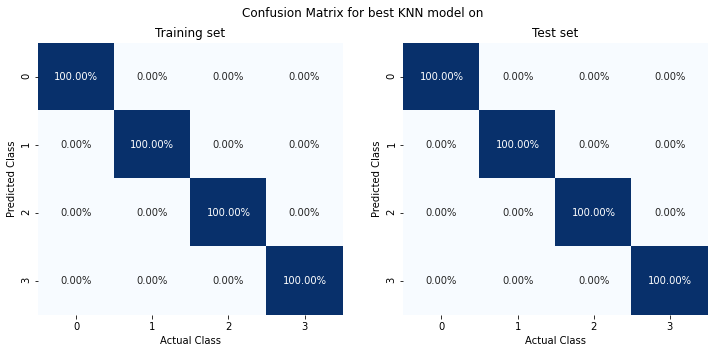

In [ ]:
# Confusion Matrix
plt.figure(figsize=(12,5))
print("Accuracy of KNN on :")
sets = [[X_train, Y_train], [X_test, Y_test]]
for i,x in enumerate(sets):
    cf_matrix, acc = knn_performance(train_data, x[0], x[1], k=1)
    print(str(i+1)+' ) '+('Training set' if i == 0 else "Test set")+': '+str(acc)+' %')    
    plt.subplot(1,2,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.title('Training set' if i == 0 else "Test set")
plt.suptitle('Confusion Matrix for best KNN model on')

print('')
plt.show()

## Naive Bayes Classifier

In [ ]:
titles = ['same covariance matrices being σ^2 * I', 'same covariance matrices for all the classes', 'different covariance matrix for each class']

print("Accuracy of Naive Bayes Classifier ")
df = pd.DataFrame(np.zeros((3,3)))
for i in range(3):
    prior_prob, class_prob = naive_bayes_classifier(X_train, Y_train, i)
    cf_matrix_train, acc_train = naive_bayes_performance(X_train, Y_train, class_prob, prior_prob)
    cf_matrix_cv, acc_cv = naive_bayes_performance(X_cv, Y_cv, class_prob, prior_prob)

    df.iloc[i,0] = "Accuracy with "+titles[i]

    df.iloc[i,1] = acc_train
    df.iloc[i,2] = acc_cv
    
df.rename(columns={0:"", 1:"Training Accuracy (%)", 2:"Validation Accuracy (%)"}, inplace=True)
df.set_index("", inplace=True)
df

Accuracy of Naive Bayes Classifier 


,Training Accuracy (%),Validation Accuracy (%)
,,
Accuracy with same covariance matrices being σ^2 * I,100.0,100.0
Accuracy with same covariance matrices for all the classes,100.0,100.0
Accuracy with different covariance matrix for each class,100.0,100.0


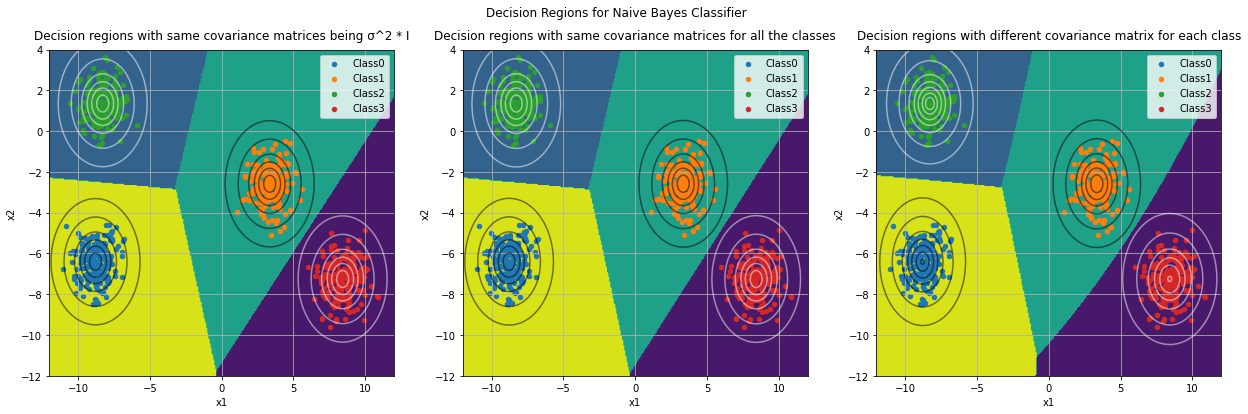

In [ ]:
plt.figure(figsize=(21,6))
plt.suptitle("Decision Regions for Naive Bayes Classifier")
for i in range(3):
    prior_prob, class_prob = naive_bayes_classifier(X_train, Y_train, i)
    X,Y,Z,pos = naive_bayes_decision_regions(X_train, class_prob, prior_prob)
    plt.subplot(1,3,i+1)
    plt.grid()
    plt.title("Decision regions with "+titles[i], pad=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    # plt.legend()
    plt.contourf(X,Y,Z)
    # sns.scatterplot(x = X.ravel(),y = Y.ravel(), hue = Z.ravel(),palette=cmap_light,legend= False)
    # sns.scatterplot(x=X1_train, y=X2_train, hue=Y_train,palette=cmap_bold, alpha=1.0, edgecolor="black",legend=False)
    L = len(prior_prob)
    for i in range(L):  
        x_class = X_train[Y_train==i]
        cs = plt.contour(X, Y, class_prob[i].pdf(pos), [0.00025,0.0075,0.05,0.1,0.15,0.2,0.23], alpha=0.5, colors='black' if i<=1 else 'white' )
        plt.scatter(x_class[:,0],x_class[:,1],label='Class'+str(i), s=20)
        plt.legend()

plt.show()


Accuracy of Naive Bayes Classifier on :
1 ) Training set: 100.0 %
2 ) Test set: 100.0 %



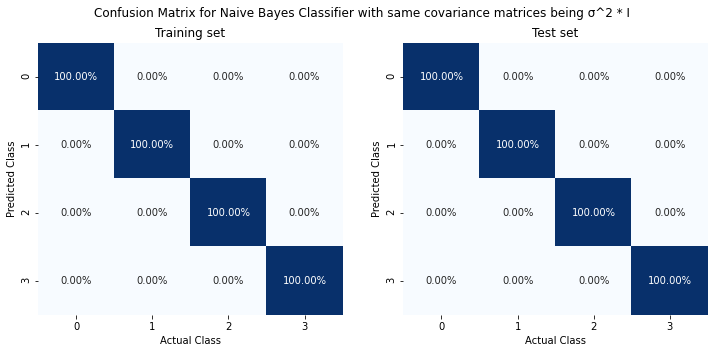

In [ ]:
plt.figure(figsize=(12,5))
print("Accuracy of Naive Bayes Classifier on :")
prior_prob, class_prob = naive_bayes_classifier(X_train, Y_train, 0)
sets = [[X_train, Y_train], [X_test, Y_test]]
for i,x in enumerate(sets):
    cf_matrix, acc = naive_bayes_performance(x[0], x[1], class_prob, prior_prob)
    print(str(i+1)+' ) '+('Training set' if i == 0 else "Test set")+': '+str(acc)+' %')
    
    plt.subplot(1,2,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.title('Training set' if i == 0 else "Test set")
plt.suptitle('Confusion Matrix for Naive Bayes Classifier with same covariance matrices being σ^2 * I')

print('')
plt.show()

# GMM Utilities

In [ ]:
def gmm_likelihood(x, funcs, wq):
    lik = 0
    for i in range(x.shape[0]):
        px = 0
        for j in range(len(funcs)):
            px += funcs[j].pdf(x[i])*wq[j]
        lik += (np.log(px) if px>0 else -100000000000000)
    return lik

def gmm_classifier(x, y, Q=1, tol=0.001, diag=False, max_iter=200):
    L = int(np.max(y))+1
    n = x.shape[0]
    gmm = []

    for l in range(L):
        x_class = x[y == l]
        nl = x_class.shape[0] 
        d = x_class.shape[1]
        prior_prob = (nl/n)
        kmeans = KMeans(Q).fit(x_class)
        labels = kmeans.labels_
        kmeans = (kmeans.cluster_centers_) 

        ## Inilialization
        wq = np.array([(labels==i).sum() for i in range(Q)])/nl # w_q = N_q/N
        resp = np.array([(labels==i) for i in range(Q)]).astype(int).T # responsibility terms
        means = [np.mean(x_class[labels==i], axis=0) for i in range(Q)] # means #initially cluster means = means required for EM ?
        cov_mat = lambda x,i : np.matmul((x-means[i]).T,(x-means[i]))/(labels==i).sum()
        covs = [cov_mat(x_class[labels==i], i) for i in range(Q)] # covariance matrices
        if(diag): 
            covs = [cov*np.eye(d) for cov in covs]
        funcs = [multivariate_normal(mean=means[i], cov=covs[i], allow_singular=True) for i in range(Q)]
        lik = -100000000000000000
        max_lik = -10000000
        it = 0

        while (True):
            if(it>max_iter): break
            resp = np.zeros((nl,Q))
            for i in range(nl):
                for j in range(Q):
                    resp[i,j] = funcs[j].pdf(x_class[i])*wq[j]
            for i in range(nl): resp[i] = resp[i]/np.sum(resp[i])
            nq = np.sum(resp, axis=0)
            wq = nq/nl
            means = np.matmul(resp.T, x_class)
            for i in range(Q): means[i] = means[i]/nq[i]
            covs = []
            for i in range(Q):
                rtmp = resp[:,i]
                for _ in range(d-1):
                    rtmp = np.c_[rtmp, resp[:,i]]
                tmp = (x_class-means[i])*rtmp
                covmat = np.matmul(tmp.T, (x_class-means[i]))/nq[i]
                if(diag):
                    covmat = covmat*np.eye(d)
                covs.append(covmat)
            try:
                funcs = [multivariate_normal(mean=means[i], cov=covs[i], allow_singular=True) for i in range(Q)]
            except:
                print("Shit")
                break
                
            new_lik = (gmm_likelihood(x_class, funcs, wq))
            if (abs(new_lik - lik) < tol): break
            lik = new_lik
            if(new_lik > max_lik):
                funcs_optimal = funcs.copy()
                wq_optimal = wq.copy()
                max_lik = new_lik
            it += 1
        
#         print('*',max_lik, lik, it)
        gmm.append([funcs_optimal, wq_optimal, prior_prob])
    return gmm

def bayes_gmm_predict(x, gmm):
    posterior_prob = []
    L = len(gmm)
    Q = len(gmm[0][0])
    for i in range(L):
        tmp = 0
        for j in range(Q):
            tmp += gmm[i][0][j].pdf(x)*gmm[i][1][j]
        tmp = gmm[i][2]*tmp
        posterior_prob.append(tmp)
    return (np.argmax(posterior_prob))

def bayes_gmm_decision_regions(gmm):
    L = len(gmm)
    x = np.linspace(-3.5,3.5,200)
    y = np.linspace(-0.5,4,200)
    X,Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y

    Z = np.empty(X.shape)
    for ix in range(X.shape[0]):
        for jx in range(X.shape[1]):
            Z[ix][jx] = bayes_gmm_predict([X[ix,jx], Y[ix,jx]], gmm)
    
    return X,Y,Z,pos

def bayes_gmm_performance(x, y, gmm):
    L = len(gmm)
    N = x.shape[0]
    y_pred = []
    for n in range(N):
        y_pred.append(bayes_gmm_predict(x[n], gmm))
    confusion_matrix = np.zeros((L,L))
    for i in range(N):
        confusion_matrix[y_pred[i], int(y[i])] += 1
    acc = (np.trace(confusion_matrix)/N)*100
    for i in range(L):
        confusion_matrix[:,i] = confusion_matrix[:,i]/(y==i).sum()
    return confusion_matrix,acc

# Dataset 1B

In [ ]:
#reading the training data and storing the features and outputs in corresponding variables
df_train= pd.read_csv("Data_1B/8/train.csv",header=None)
df_train.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_train['y']=df_train['y'].astype('int32')
train_data = np.array(df_train[['x1','x2','y']]) 
X_train = np.array(df_train[['x1','x2']]) 
X1_train = train_data[:,0]; X2_train = train_data[:,1] ; Y_train = train_data[:,2]
#print(df_train.head(5))


#reading the test data and storing the features and outputs in corresponding variables
df_test= pd.read_csv("Data_1B/8/dev.csv",header=None)
df_test.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_test['y']=df_test['y'].astype('int32')
test_data = np.array(df_test[['x1','x2','y']])
N_dev = test_data.shape[0]
np.random.shuffle(test_data)
X_test = test_data[:N_dev//2, [0,1]]; Y_test = test_data[:N_dev//2,2]
X1_test = X_test[:,0]; X2_test = X_test[:,1];
cv_data = test_data[N_dev//2:,:]
X_cv = test_data[N_dev//2:, [0,1]]; Y_cv = test_data[N_dev//2:,2]
X1_cv = X_cv[:,0]; X2_cv = X_cv[:,1];

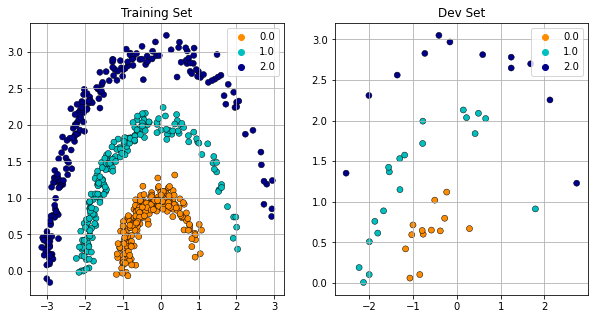

In [ ]:
#Visualising the dataset in 2d
cmap_bold = ['darkorange', 'c', 'darkblue']         #defining the cmap_bold
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue']) #definig the cmap_light for decision boundaries 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.grid()
sns.scatterplot(x=X1_train, y=X2_train, hue=Y_train,palette=cmap_bold, alpha=1.0, edgecolor="black")             
plt.legend()
plt.title("Training Set")

plt.subplot(1,2,2)
plt.grid()
sns.scatterplot(x=X1_test, y=X2_test, hue=Y_test,palette=cmap_bold, alpha=1.0, edgecolor="black")
plt.legend()
plt.title("Dev Set")
plt.show()

## KNN Classifier

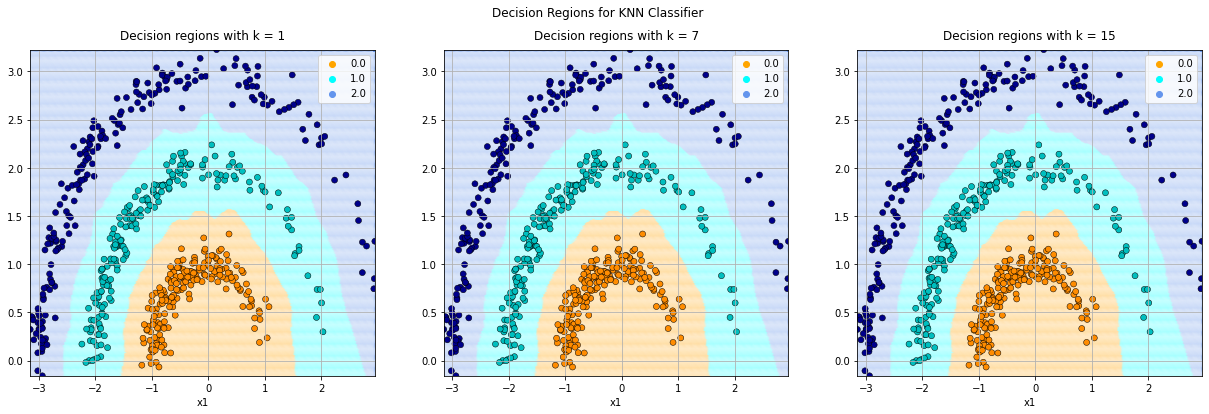

In [ ]:
titles = ['k = 1', 'k = 7', 'k = 15']
k = [1,7,15]
#plotting the decision regions
plt.figure(figsize=(21,6))
plt.suptitle("Decision Regions for KNN Classifier")
for i in range(3):
    X,Y,Z = knn_decision_regions(train_data,k[i])
    plt.subplot(1,3,i+1)
    plt.grid()
    plt.title("Decision regions with "+titles[i], pad=10)
    plt.xlabel('x1')
    plt.xlim(X1_train.min(),X1_train.max())
    plt.ylim(X2_train.min(),X2_train.max())
    sns.scatterplot(x = X.ravel(),y = Y.ravel(), hue = Z.ravel(),palette=cmap_light,legend= True)
    sns.scatterplot(x=X1_train, y=X2_train, hue=Y_train,palette=cmap_bold, alpha=1.0, edgecolor="black",legend=False)

plt.show()

In [ ]:
#table of accuracies of KNN classifier with different values of k
df = pd.DataFrame(np.zeros((3,3)))
actual_cv = Y_cv
actual_train = Y_train
score_cv,score_train = [],[]
for i in range(3):

    predicted_cv = knn_classifier(train_data,cv_data,k[i])
    score_cv.append(accuracy_metric(actual_cv,predicted_cv))
    predicted_train = knn_classifier(train_data,train_data,k[i])
    score_train.append(accuracy_metric(actual_train,predicted_train))


    df.iloc[i,0] = "Accuracy with " + titles[i]
    df.iloc[i,1] = score_train[i]
    df.iloc[i,2] = score_cv[i]

df.rename(columns={0:"", 1:"Training Accuracy (%)", 2:"Validation Accuracy (%)"}, inplace=True)
df.set_index("", inplace=True)
df

,Training Accuracy (%),Validation Accuracy (%)
,,
Accuracy with k = 1,100.0,100.0
Accuracy with k = 7,100.0,100.0
Accuracy with k = 15,100.0,100.0


Accuracy of KNN on :
1 ) Training set: 100.0 %
2 ) Test set: 100.0 %



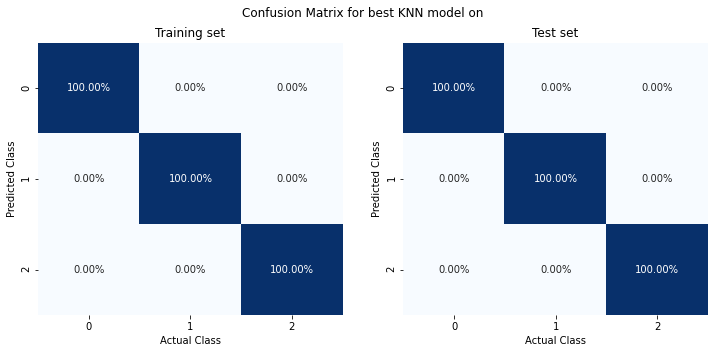

In [ ]:
# Confusion Matrix
plt.figure(figsize=(12,5))
print("Accuracy of KNN on :")
sets = [[X_train, Y_train], [X_test, Y_test]]
for i,x in enumerate(sets):
    cf_matrix, acc = knn_performance(train_data, x[0], x[1], k=1)
    print(str(i+1)+' ) '+('Training set' if i == 0 else "Test set")+': '+str(acc)+' %')    
    plt.subplot(1,2,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.title('Training set' if i == 0 else "Test set")
plt.suptitle('Confusion Matrix for best KNN model on')

print('')
plt.show()




## Bayes Classifier with GMM 

### Full covariance matrix


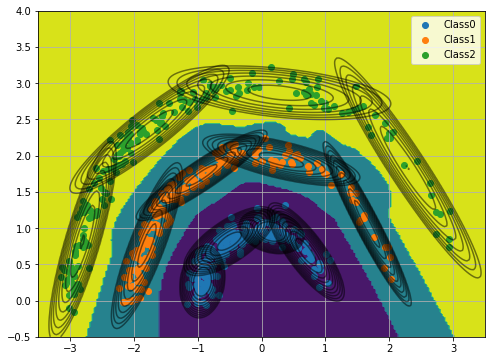

In [ ]:
#GMM with full covariance matrix
Q = 4
gmm = gmm_classifier(X_train, Y_train, Q)
L = len(gmm)

X,Y,Z,pos = bayes_gmm_decision_regions(gmm)
plt.figure(figsize=(8,6))
levels = np.logspace(-1, 0.6, 10)
plt.contourf(X,Y,Z)
    
for i in range(L):  
    x_class = X_train[Y_train==i]
    for j in range(Q):
        cs = plt.contour(X, Y, gmm[i][0][j].pdf(pos), levels, colors='black', alpha=0.5)
    plt.scatter(x_class[:,0],x_class[:,1],label='Class'+str(i))
    plt.legend()

plt.grid()
plt.show()

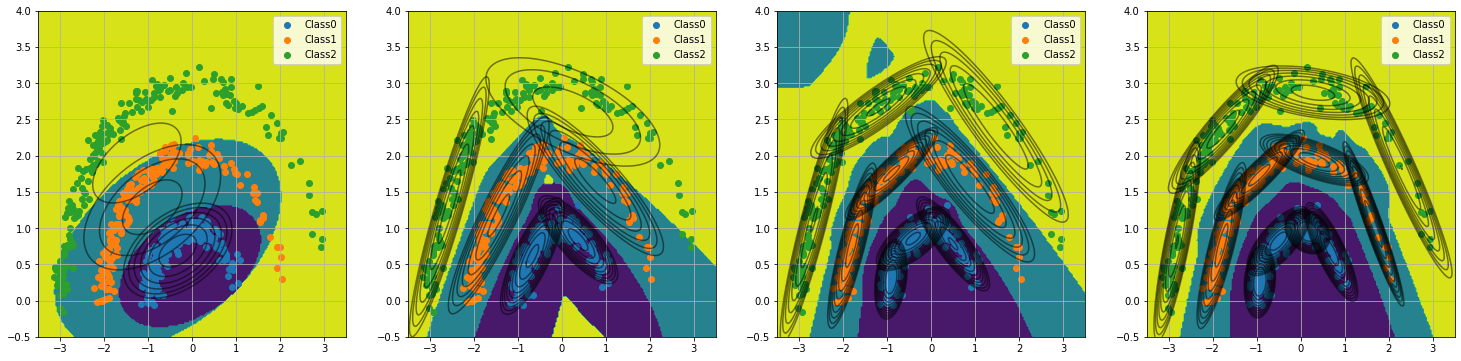

In [ ]:
Q_list = [1,2,3,4]
plt.figure(figsize=(32,6))
for j in range(len(Q_list)):
      
    Q = Q_list[j]
    gmm = gmm_classifier(X_train, Y_train, Q)
    L = len(gmm)

    X,Y,Z,pos = bayes_gmm_decision_regions(gmm)
    plt.subplot(1,len(Q_list)+1,j+1)
    levels = np.logspace(-1, 0.6, 10)
    plt.contourf(X,Y,Z)
    plt.grid()  
    for i in range(L):  
        x_class = X_train[Y_train==i]
        for j in range(Q):
            cs = plt.contour(X, Y, gmm[i][0][j].pdf(pos), levels, colors='black', alpha=0.5)
        plt.scatter(x_class[:,0],x_class[:,1],label='Class'+str(i))
        plt.legend()

plt.show()

Accuracy of Bayes Classifier with GMN for each class on :
1 ) Training set: 100.0 %
2 ) Test set: 100.0 %



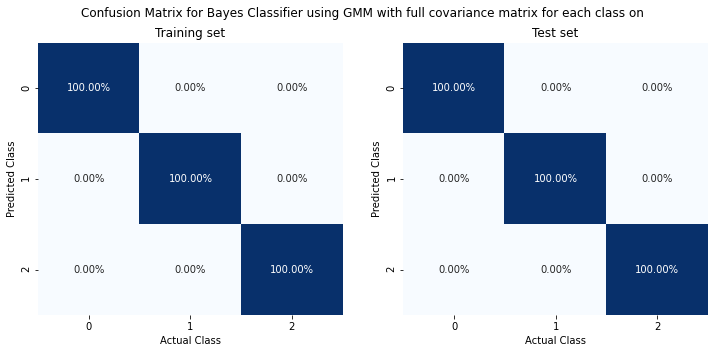

In [ ]:
plt.figure(figsize=(12,5))
print("Accuracy of Bayes Classifier with GMN for each class on :")
gmm = gmm_classifier(X_train, Y_train, 4)
sets = [[X_train, Y_train], [X_test, Y_test]]
for i,x in enumerate(sets):
    cf_matrix,acc = bayes_gmm_performance(x[0], x[1], gmm)
    print(str(i+1)+' ) '+('Training set' if i == 0 else "Test set")+': '+str(acc)+' %')
    
    plt.subplot(1,2,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.title('Training set' if i == 0 else "Test set")
plt.suptitle('Confusion Matrix for Bayes Classifier using GMM with full covariance matrix for each class on')

print('')
plt.show()

In [ ]:
#training and validation accuracy for Q=[1,2,3,4]
for Q in Q_list:
  gmm = gmm_classifier(X_train,Y_train,Q)
  cf_matrix,acc_train = bayes_gmm_performance(X_train,Y_train,gmm)
  cf_matrix,acc_cv = bayes_gmm_performance(X_cv,Y_cv,gmm)
  print('Value of Q: ',Q,'\n','training acc: ',acc_train,'\n','validation acc: ',acc_cv )

Value of Q:  1 
 training acc:  92.16666666666666 
 validation acc:  86.66666666666667
Value of Q:  2 
 training acc:  99.5 
 validation acc:  100.0
Value of Q:  3 
 training acc:  99.83333333333333 
 validation acc:  100.0
Value of Q:  4 
 training acc:  100.0 
 validation acc:  100.0


### diagonal covariance matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


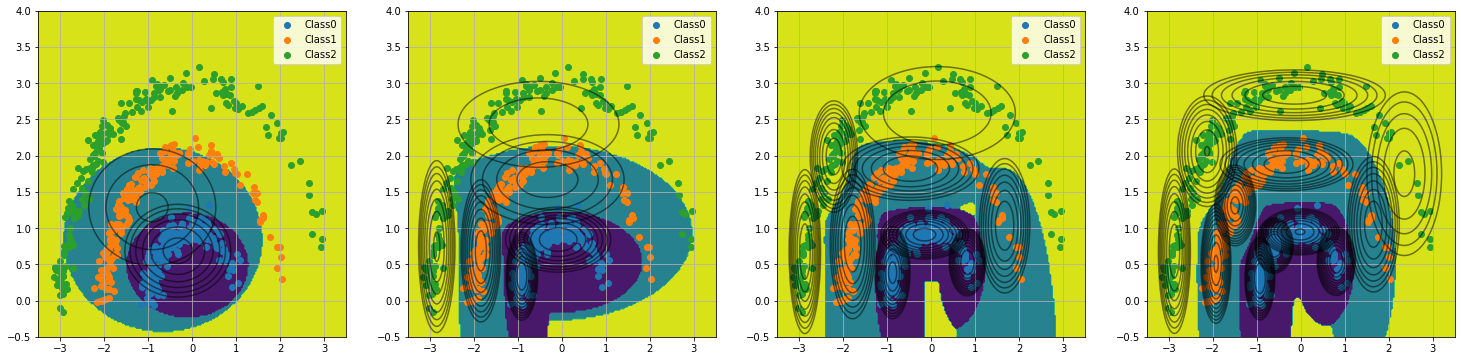

In [ ]:
Q_list = [1,2,3,4]
plt.figure(figsize=(32,6))
for j in range(len(Q_list)):
      
    Q = Q_list[j]
    gmm = gmm_classifier(X_train, Y_train, Q, diag=True)
    L = len(gmm)

    X,Y,Z,pos = bayes_gmm_decision_regions(gmm)
    plt.subplot(1,len(Q_list)+1,j+1)
    levels = np.logspace(-1, 0.6, 10)
    plt.contourf(X,Y,Z)
    plt.grid()  
    for i in range(L):  
        x_class = X_train[Y_train==i]
        for j in range(Q):
            cs = plt.contour(X, Y, gmm[i][0][j].pdf(pos), levels, colors='black', alpha=0.5)
        plt.scatter(x_class[:,0],x_class[:,1],label='Class'+str(i))
        plt.legend()

plt.show()

Accuracy of Bayes Classifier with GMN for each class on :
1 ) Training set: 100.0 %
2 ) Test set: 100.0 %



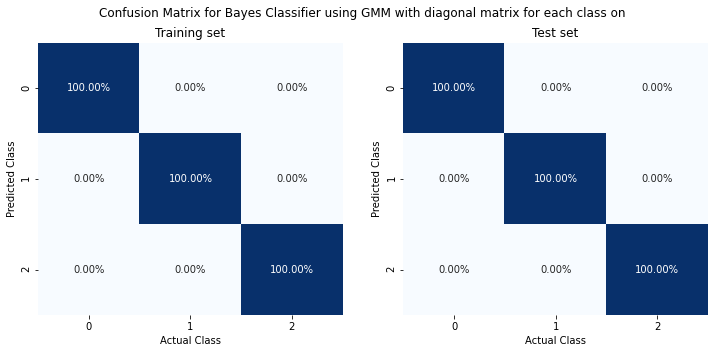

In [ ]:
plt.figure(figsize=(12,5))
print("Accuracy of Bayes Classifier with GMN for each class on :")
gmm = gmm_classifier(X_train, Y_train, 4 , diag=True)
sets = [[X_train, Y_train], [X_test, Y_test]]
for i,x in enumerate(sets):
    cf_matrix,acc = bayes_gmm_performance(x[0], x[1], gmm)
    print(str(i+1)+' ) '+('Training set' if i == 0 else "Test set")+': '+str(acc)+' %')
    
    plt.subplot(1,2,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.title('Training set' if i == 0 else "Test set")
plt.suptitle('Confusion Matrix for Bayes Classifier using GMM with diagonal matrix for each class on')

print('')
plt.show()

In [ ]:
#training and validation accuracy for Q=[1,2,3,4] for diagonal cov matrix case
for Q in Q_list:
  gmm = gmm_classifier(X_train,Y_train,Q , diag=True)
  cf_matrix,acc_train = bayes_gmm_performance(X_train,Y_train,gmm)
  cf_matrix,acc_cv = bayes_gmm_performance(X_cv,Y_cv,gmm)
  print('Value of Q: ',Q,'\n','training acc: ',acc_train,'\n','validation acc: ',acc_cv )

Value of Q:  1 
 training acc:  89.16666666666667 
 validation acc:  86.66666666666667
Value of Q:  2 
 training acc:  97.0 
 validation acc:  95.55555555555556
Value of Q:  3 
 training acc:  99.5 
 validation acc:  100.0
Value of Q:  4 
 training acc:  100.0 
 validation acc:  100.0


## Bayes Classifier with K-Nearest Neighbours method 

In [ ]:
#reading the training data and storing the features and outputs in corresponding variables
df_train= pd.read_csv("Data_1B/8/train.csv",header=None)
df_train.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_train['y']=df_train['y'].astype('int32')
train_data = np.array(df_train[['x1','x2','y']]) 
X_train = np.array(df_train[['x1','x2']]) 
X1_train = train_data[:,0]; X2_train = train_data[:,1] ; Y_train = train_data[:,2]
#print(df_train.head(5))


#reading the test data and storing the features and outputs in corresponding variables
df_test= pd.read_csv("Data_1B/8/dev.csv",header=None)
df_test.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_test['y']=df_test['y'].astype('int32')
test_data = np.array(df_test[['x1','x2','y']])
X_test = np.array(df_test[['x1','x2']]) 
X1_test = test_data[:,0]; X2_test = test_data[:,1] ; Y_test = test_data[:,2]

In [ ]:
#calculate the distance of the training examples with the test_data point
def distance(train,test_input):
    distances = train.copy()
    distances['distance']= np.sqrt((distances['x1']-test_input[0])**2+(distances['x2']-test_input[1])**2)
    return distances

def get_distances_of_each_class(train,test_input,k=1):
    distances = distance(train, test_input)  
    distances_each_class=[]         # kth largest distance for each class
    for i in range(3):
        dist_i=distances[distances['y']==i]
        dist_i_sorted=dist_i.sort_values(by='distance')
        distances_each_class.append(dist_i_sorted.iloc[k,-1])
    return distances_each_class


# Make a classification prediction with neighbors
def knn_method_predict(train, test_input, k=1):
	distances_each_class = get_distances_of_each_class(train, test_input, k)
	prediction = np.argmin(distances_each_class)
	return prediction

def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

def knn_method(train,test,k=10):
    predictions = []
    if type(test) is np.ndarray:
      test=pd.DataFrame(test)
    for i in range(test.shape[0]):
        output = knn_method_predict(train,test.iloc[i],k)
        predictions.append(output)
    return predictions


In [ ]:
def knn_confusion_matrix(actual_data,predicted_data):
    cf=np.zeros((3,3))
    for i in range(len(actual_data)):
        cf[int(predicted_data[i]),int(actual_data[i])]+=1
    for i in range(3):
      cf[:,i]=cf[:,i]/np.sum(cf,axis=1)[i]
    return cf

test score: 
 {10: 100.0, 20: 98.88888888888889} 
 train_score: 
 {10: 99.5, 20: 98.5}


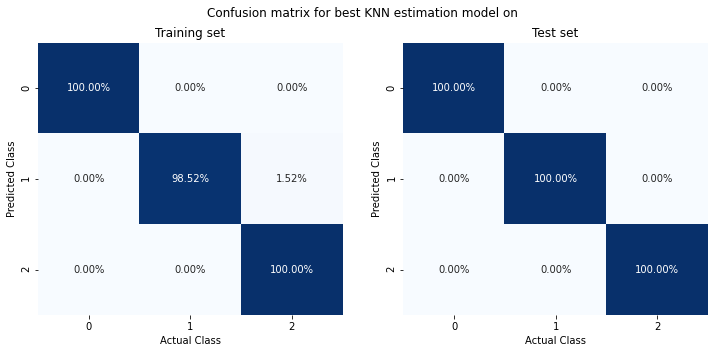

In [ ]:
actual_test = Y_test
actual_train = Y_train
k = [10,20]
score_test,score_train={},{}
for i in k:
    predicted_test = knn_method(df_train,df_test,i)
    predicted_train = knn_method(df_train,df_train,i)
    score_test[i] = accuracy_metric(actual_test,predicted_test)
    score_train[i] = accuracy_metric(actual_train,predicted_train)
    if(i==10):
        cf_train_best=knn_confusion_matrix(actual_train,predicted_train)
        cf_test_best=knn_confusion_matrix(actual_test,predicted_test)
        
print('test score:','\n',score_test,'\n','train_score:','\n',score_train)

#confusion matrix 
cfs=[cf_train_best,cf_test_best]
plt.figure(figsize=(12,5))
plt.suptitle('Confusion matrix for best KNN estimation model on')
for i in range(2):
    plt.subplot(1,2,i+1)
    sns.heatmap(cfs[i],annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.title('Training set' if i==0 else 'Test set')    
plt.show()

In [ ]:
def knn_decision_regions(X_train,k=1):
    x1_min,x1_max = X_train[:,0].min(),X_train[:,0].max()
    x2_min,x2_max = X_train[:,1].min(),X_train[:,1].max()
    x = np.linspace(x1_min,x1_max,300)
    y = np.linspace(x2_min,x2_max,300)
    X,Y = np.meshgrid(x,y)
    X_train=pd.DataFrame(X_train,columns=['x1','x2','y'])
    Z = knn_method(X_train, np.c_[X.ravel(), Y.ravel()],k)
    Z = np.array(Z).reshape(X.shape)
    return X,Y,Z

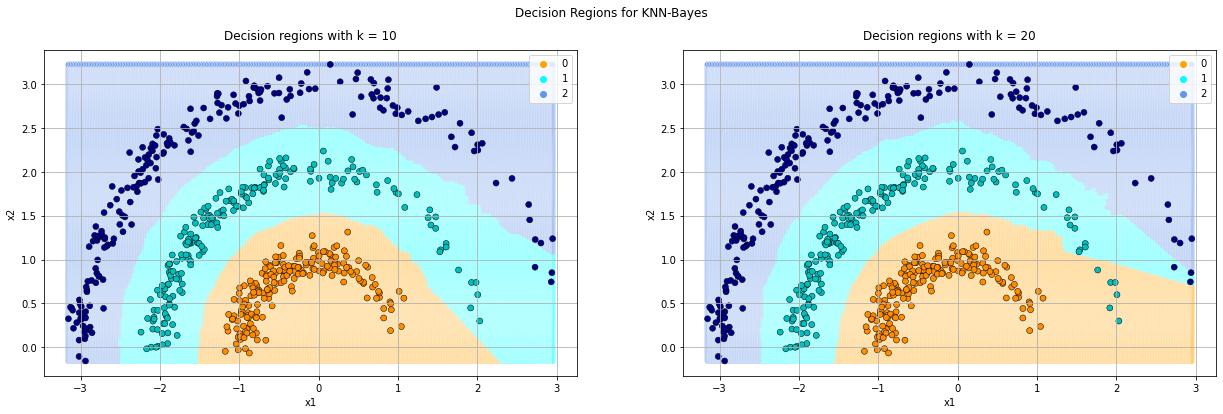

In [ ]:
titles = ['k = 10', 'k = 20']
k = [10,20]
#plotting the decision regions
plt.figure(figsize=(21,6))
plt.suptitle("Decision Regions for KNN-Bayes")
for i in range(2):
    X,Y,Z = knn_decision_regions(train_data,k[i])
    plt.subplot(1,2,i+1)
    plt.grid()
    plt.title("Decision regions with "+titles[i], pad=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    sns.scatterplot(x = X.ravel(),y = Y.ravel(), hue = Z.ravel(),palette=cmap_light,legend= True)
    sns.scatterplot(x=X1_train, y=X2_train, hue=Y_train,palette=cmap_bold, alpha=1.0, edgecolor="black",legend=False)

plt.show()

# Real World Data Utilities

In [ ]:
def bayes_gmm_predict_v(x, gmm):
    posterior_prob = []
    L = len(gmm)
    Q = len(gmm[0][0])
    p = np.zeros((L, x.shape[0]))
    for i in range(L):
        for k in range(x.shape[0]):
            tmp = 0
            for j in range(Q):
                tmp += gmm[i][0][j].pdf(x[k])*gmm[i][1][j]
            p[i][k] = math.log(tmp) if tmp>0 else -10000000
    p = np.sum(p, axis = 1)
    return (np.argmax(p))

def real_world_dataset_performance(X, y, gmm):
    L = len(gmm)
    y_pred = []
    for x in X:
        y_pred.append(bayes_gmm_predict_v(x, gmm))
    confusion_matrix = np.zeros((L,L))
    for i in range(len(X)):
        confusion_matrix[y_pred[i], int(y[i])] += 1
    acc = (np.trace(confusion_matrix)/len(X))*100
    for i in range(L):
        confusion_matrix[:,i] = confusion_matrix[:,i]/(y==i).sum()
    return confusion_matrix,acc

# Dataset 2A

In [ ]:
classes = ['highway', 'insidecity', 'mountain', 'opencountry', 'tallbuilding']
class_to_ind = {}
for i,c in enumerate(classes):
    class_to_ind[c] = i
class_to_ind

{'highway': 0,
 'insidecity': 1,
 'mountain': 2,
 'opencountry': 3,
 'tallbuilding': 4}

In [ ]:
# Loading Dataset 2A
Y_train = []
X_train = None
print('Training Set : ')
for c in classes:
    fil = './2A/'+c+'/train.csv'
    df = pd.read_csv(fil)
    if(X_train is None):
        X_train = np.array(df.iloc[:,range(1,25,1)])
    else:
        X_train = np.r_[X_train, np.array(df.iloc[:,range(1,25,1)])]
    Y_train = Y_train + [class_to_ind[c]]*df.shape[0]
    print(' ',c, df.shape[0])
Y_train = np.array(Y_train)

Y_test = []
Y_valid = []
X_valid = None
X_test = None
print('Dev Set : ')
for c in classes:
    fil = './2A/'+c+'/dev.csv'
    df = pd.read_csv(fil)
    nc = df.shape[0]
    if(X_test is None):
        X_test = np.array(df.iloc[int(0.6*nc):,range(1,25,1)])
        X_valid = np.array(df.iloc[:int(0.6*nc),range(1,25,1)])
    else:
        X_test = np.r_[X_test, np.array(df.iloc[int(0.6*nc):,range(1,25,1)])]
        X_valid = np.r_[X_valid, np.array(df.iloc[:int(0.6*nc),range(1,25,1)])]
    Y_valid = Y_valid + [class_to_ind[c]]*int(0.6*nc)
    Y_test = Y_test + [class_to_ind[c]]*(nc - int(0.6*nc))
    print(' ',c, df.shape[0])
Y_test = np.array(Y_test)
Y_valid = np.array(Y_valid)
Y_valid.shape

Training Set : 
  highway 182
  insidecity 215
  mountain 261
  opencountry 287
  tallbuilding 249
Dev Set : 
  highway 52
  insidecity 62
  mountain 75
  opencountry 82
  tallbuilding 71


In [ ]:
# To calculate training and validation accuracies for different values of Q
print("Accuracy of GMM Classifier on :")
sets = [[X_train, Y_train], [X_valid, Y_valid]]
for q in range(1,11,1):
    print('Q = ',q,end=' & ')
    gmm = gmm_classifier(X_train,Y_train, q, tol=0.0005, diag=False)
    for i,x in enumerate(sets):
        cf_matrix,acc = bayes_gmm_performance(x[0], x[1], gmm)
        print(str(round(acc,2))+' \\%', end=' ')
    print('\\\\ ')

In [ ]:
# To plot confusion matrix on training and test set
plt.figure(figsize=(16,5))
print("Accuracy of GMM Classifier on :")
gmm = gmm_classifier(X_train,Y_train, 4, tol=0.0005, diag=False)
sets = [[X_train, Y_train], [X_test, Y_test]]
for i,x in enumerate(sets):
    cf_matrix,acc = bayes_gmm_performance(x[0], x[1], gmm)
    print(str(i+1)+' ) '+('Training set' if i == 0 else "Validation set")+': '+str(acc)+' %')
    
    plt.subplot(1,2,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.yticks(rotation=45)
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.title('Training set' if i == 0 else "Test set")
plt.suptitle('Confusion Matrix for GMM :')

print('')
plt.show()

# DataSet 2B

In [ ]:
# Loading Dataset 2B
X_train = np.zeros((1,23))
Y_train = []
X_train_set = []
Y_train_set = []

for c in classes:
    filnames = os.listdir('./2B/'+c+'/train')
    for fil in filnames:
        with open('./2B/'+c+'/train/'+fil) as f:
            a = f.readlines()
            a = list(map(lambda x:x.strip('\n').split(' '), a))
            a = list(map(lambda x:list(map(float,x)),a))
            a = np.array(a)
            X_train = np.r_[X_train, a]
            Y_train = Y_train + [class_to_ind[c]]*a.shape[0]
        X_train_set.append(a)
        Y_train_set.append(class_to_ind[c])
Y_train = np.array(Y_train)
Y_train_set = np.array(Y_train_set)
X_train = X_train[1:,:]

X_test_set = []
Y_test_set = []
X_valid_set = []
Y_valid_set = []

for c in classes:
    filnames = os.listdir('./2B/'+c+'/dev')
    nc = len(filnames)
    for i,fil in enumerate(filnames):
        with open('./2B/'+c+'/dev/'+fil) as f:
            a = f.readlines()
            a = list(map(lambda x:x.strip('\n').split(' '), a))
            a = list(map(lambda x:list(map(float,x)),a))
            a = np.array(a)
        if(i>=int(0.6*nc)):
            X_test_set.append(a)
            Y_test_set.append(class_to_ind[c])
        else:
            X_valid_set.append(a)
            Y_valid_set.append(class_to_ind[c])
Y_test_set = np.array(Y_test_set)
Y_valid_set = np.array(Y_valid_set)

In [ ]:
# Calculating training and validation accuracies for different Q and saving the models along
gmms = [None]
for q in range(1,16,1):
    gmm = gmm_classifier(X_train, Y_train, q, tol=0.0005, max_iter=50, diag=True)
    gmms.append(gmm)
    cf_train,acc_train = real_world_dataset_performance(X_train_set, Y_train_set, gmm)    
    cf_dev,acc_dev = real_world_dataset_performance(X_valid_set, Y_valid_set, gmm)
    print("Q = ",q," & ", str(round(acc_train,2))+' \\%', " & ",str(round(acc_dev,2))+' \\% \\\\')

In [ ]:
# Plotting confusion matrix for training and test set for dataset 2B
plt.figure(figsize=(16,5))
print("Accuracy of GMM Classifier on :")
# gmm = gmm_classifier(X_train, Y_train, 4, tol=0.0005, max_iter=50, diag=True)
gmm = gmms[6]
sets = [[X_train_set, Y_train_set], [X_test_set, Y_test_set]]
for i,x in enumerate(sets):
    cf,acc = real_world_dataset_performance(x[0], x[1], gmm)
    print(str(i+1)+' ) '+('Training set' if i == 0 else "Validation set")+': '+str(acc)+' %')
    
    plt.subplot(1,2,i+1)
    sns.heatmap(cf, annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.yticks(rotation=45)
    plt.xlabel('Actual Class')
    plt.ylabel('Predicted Class')
    plt.title('Training set' if i == 0 else "Test set")
plt.suptitle('Confusion Matrix for GMM :')

print('')
plt.show()